<a href="https://colab.research.google.com/github/jordan-palmer/FlameNEST_examples/blob/main/FlameNEST_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FlameNEST Fitting
This notebook aims to demonstrate the fitting capabilities of FlameNEST. FlameNEST can accurately fit nuisance parameters by minimising the likelihood.

First, we need to install FlameNEST

In [1]:
%%capture
##
# Flamedisx colab setup
##
import sys
%tensorflow_version 2.x
!git clone https://github.com/robertsjames/flamedisx.git
%cd flamedisx
!git checkout RJ-test_fits
!python setup.py develop
%cd ..

In [2]:
!cp flamedisx/flamedisx/TFP_files/* ../usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/

Check the GPU

In [3]:
!nvidia-smi

Mon Mar 21 16:28:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Restart the runtime and continue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flamedisx as fd
from time import clock
import time
import tqdm
import tensorflow as tf

Did not find 6luf3gtmmu in cache, downloading https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/XENON1T_s1_xyz_ly_kr83m_SR0_pax-642_fdc-AdCorrTPF.json
Did not find s4rqbgz5ez in cache, downloading https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/XENON1T_s2_xy_ly_SR0_24Feb2017.json


What are the current fittable parameters in the LUX ER source?

In this source, we can float g1 and elife

In [2]:
fd.lux.LUXERSource().print_config()

Parameter                               Default             
------------------------------------------------------------
elife                                   800000.0            
g1                                      0.117               

Constant (could be made a function)     Default             
------------------------------------------------------------
double_pe_fraction                      0.173               
electron_acceptance                     1.0                 
energy_spectrum_rate_multiplier         1.0                 
s2_photon_acceptance                    1.0                 

Other attribute                         Default             
------------------------------------------------------------
check_acceptances                       True                
check_efficiencies                      True                
drift_velocity                          0.000147525020107...
energies                                tf.Tensor([ 0.   ...
radius                

Let's try and fit g1!

We will fit parameters out from MC data simulated with FlameNEST

In [3]:
# 'par name': (minimum, maximum, number of anchor points)
nuisance_range = {'g1':(0.09, 0.15, 2)}
# how many events to fit
n_events = 100
# energy of the ER source
min_energy = 40
max_energy = 40
num_energies = 1
### Only need to construct likelihood once if your models are constant
# sources: sources we want to fit against the data
# batch size: how many events per batch
# free_rates: keep the number of ER events floatable
Likelihood = fd.LogLikelihood(sources = dict(er=fd.lux.LUXERSource),
                              batch_size = 20,
                              free_rates = ('er'),
                              arguments = dict(er={'energy_min':min_energy, 'energy_max':max_energy, 'num_energies':num_energies}),
                              g1 = nuisance_range['g1'])

### Simulate dataset and pass it in
Likelihood.set_data(fd.lux.LUXERSource(energy_min=min_energy, energy_max=max_energy, num_energies=num_energies).simulate(n_events))

Estimating mus: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Perform one fit and print the result

In [4]:
Likelihood_guess = Likelihood.guess() # provide a guess (default values in the simulation)
bestfit = Likelihood.bestfit(guess=Likelihood_guess, optimizer='scipy',use_hessian=True) # fit
print(bestfit) # fit results

{'er_rate_multiplier': 100.00999380890163, 'g1': 0.11583652815192509}


Okay, we fit the correct g1! 

Note: if the events we simulate contain large fluctuations, we might not fit the exact g1 and that is okay


Now we can take a look at how the likelihood looks with respect to g1. 

In [5]:
input_param_values = np.linspace(nuisance_range['g1'][0], nuisance_range['g1'][1], 30)
likelihood_evals = []
for value in input_param_values:
  input_values = {'g1':value}
  likelihood_evals.append(Likelihood.minus2_ll(**input_values)[0])

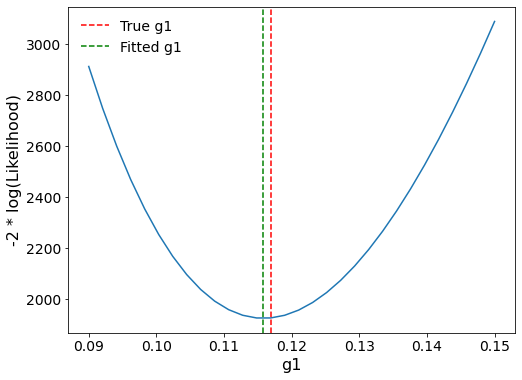

In [6]:
plt.figure(figsize=(8,6))
plt.plot(input_param_values, likelihood_evals)
plt.axvline(Likelihood_guess['g1'], color='r', linestyle='--', label='True '+'g1')
plt.axvline(bestfit['g1'], color='green', linestyle='--', label='Fitted '+'g1')
plt.xlabel('g1', fontsize=16)
plt.ylabel('-2 * log(Likelihood)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14, frameon=False)
plt.savefig('/content/g1fit.png',dpi=200)
plt.show()

Fit g1 and elifetime simultaneously

In [8]:
n_events = 200
nuisance_range = {'elife':(700000, 900000, 2), 'g1':(0.09, 0.15, 2)}
min_energy = 40
max_energy = 40
num_energies = 1
### Only need to construct likelihood once if your models are constant
Likelihood = fd.LogLikelihood(sources = dict(er=fd.lux.LUXERSource),
                              batch_size = 20,
                              progress=True,
                              free_rates = ('er'),
                              arguments = dict(er={'energy_min':min_energy, 'energy_max':max_energy, 'num_energies':num_energies}),
                              g1 = nuisance_range['g1'],
                              elife = nuisance_range['elife'])

Estimating mus: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


In [9]:
Likelihood.set_data(fd.lux.LUXERSource(energy_min=min_energy, energy_max=max_energy, num_energies=1).simulate(n_events))
bestfit = Likelihood.bestfit(guess=Likelihood.guess(), optimizer='scipy', use_hessian=True)
print(bestfit)

{'er_rate_multiplier': 200.00998491385567, 'g1': 0.11678301052481438, 'elife': 837255.7946282167}


Visualise the 2D likelihood function, takes a few minutes

In [11]:
input_elife_values = np.linspace(nuisance_range['elife'][0], nuisance_range['elife'][1], 30)
input_g1_values = np.linspace(nuisance_range['g1'][0], nuisance_range['g1'][1], 30)

likelihood_evals = []
for g1_value in input_g1_values:
  inner_evals = []

  for elife_value in input_elife_values:
    input_values = {'g1':g1_value, 'elife':elife_value, 'er_rate_multiplier':bestfit['er_rate_multiplier']}
    inner_evals.append(Likelihood.minus2_ll(**input_values)[0])

  likelihood_evals.append(inner_evals)

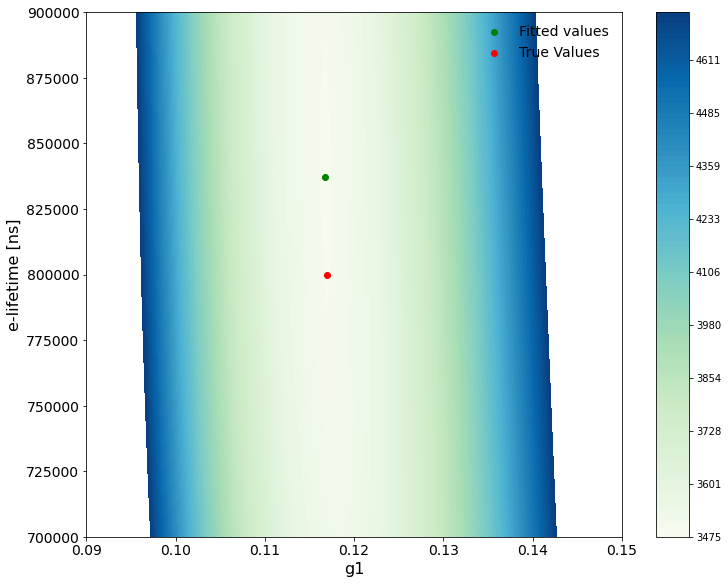

In [16]:
X=np.asarray(input_g1_values)
Y=np.asarray(input_elife_values)
X, Y = np.meshgrid(X, Y, indexing='ij')
Z=np.asarray(likelihood_evals)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(10,8)
vmin = 3475
vmax = 4725
levels = np.linspace(vmin, vmax, 100)
CS=ax.contourf(X, Y, Z, 100, cmap='GnBu', levels=levels, vmin=vmin, vmax=vmax)
plt.scatter(bestfit['g1'], bestfit['elife'], color='g', label='Fitted values') # Fitted values
plt.scatter(0.117, 800000, color='r', label='True Values') # Fitted values

ax.set_xlabel('g1', fontsize=16)
ax.set_ylabel('e-lifetime [ns]', fontsize=16)
cbar = fig.colorbar(CS,)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14, frameon=False)
plt.savefig('/content/2dfit.png', dpi=200)
plt.show()